## Residual network

Use the model subclassing API together with custom layers to create a residual network architecture. the train your custom model on the Fashion-MNIST dataset by using a custom training loop and implementing the automatic differentiation tools in Tensorflow to calculate the gradients for backpropagation.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, BatchNormalization, Conv2D, Dense, Flatten, Add
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

#### The Fashion-MNIST dataset

Use the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). It consists of a training set of 60,000 images of fashion items with corresponding labels, and a test set of 10,000 images. The images have been normalised and centred. The dataset is frequently used in machine learning research, especially as a drop-in replacement for the MNIST dataset. 

#### Load the dataset

In [2]:
# Load and preprocess the Fashion-MNIST dataset

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)

train_images = train_images[:5000] / 255.
train_labels = train_labels[:5000]

test_images = test_images / 255.

train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
# Create Dataset objects for the training and test sets

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(32)

In [4]:
# Get dataset labels

image_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#### Create custom layers for the residual blocks

Create a first custom layer for a residual block of your network.

The custom layer class should have `__init__`, `build` and `call` methods. The `__init__` method has been completed for you. It calls the base `Layer` class initializer, passing on any keyword arguments

In [11]:
class ResidualBlock(Layer):

    def __init__(self, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        
    def build(self, input_shape):
       
        self.batch_norm_1 = BatchNormalization(input_shape=input_shape,
                                              name='batch_norm1')
        self.conv2d_1 = Conv2D(input_shape[-1], (3,3), padding='SAME',
                               name='conv2d_1', activation=None)
        self.batch_norm_2 = BatchNormalization(name='batch_norm2')
        self.conv2d_2 = Conv2D(input_shape[-1], (3,3), padding='SAME',
                               name='conv2d_2', activation=None)
        
        
        
    def call(self, inputs, training=False):
       
        x = self.batch_norm_1(inputs=inputs, training=training)
        x = tf.nn.relu(x)
        x = self.conv2d_1(x)
        x = self.batch_norm_2(inputs=x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2d_2(x)
        output = tf.add(inputs, x)
        return output

        
        

In [12]:
# Test your custom layer - the following should create a model using your layer

test_model = tf.keras.Sequential([ResidualBlock(input_shape=(28, 28, 1), name="residual_block")])
test_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
residual_block (ResidualBloc (None, 28, 28, 1)         28        
Total params: 28
Trainable params: 24
Non-trainable params: 4
_________________________________________________________________


Create a second custom layer for a residual block of the network. This layer will be used to change the number of filters within the block.

In [15]:
class FiltersChangeResidualBlock(Layer):

    def __init__(self, out_filters, **kwargs):
        
        super(FiltersChangeResidualBlock, self).__init__(**kwargs)
        self.out_filters = out_filters
        
        
    def build(self, input_shape):
       
        self.batch_norm_1 = BatchNormalization(input_shape=input_shape,
                                              name='batch_norm1')
        self.conv2d_1 = Conv2D(input_shape[-1], (3,3), padding='SAME',
                               name='conv2d_1', activation=None)
        self.batch_norm_2 = BatchNormalization(name='batch_norm2')
        self.conv2d_2 = Conv2D(self.out_filters, (3,3), padding='SAME',
                               name='conv2d_2', activation=None)
        self.conv2d_3 = Conv2D(self.out_filters, (1,1), activation=None)
        
        
        
    def call(self, inputs, training=False):
        
        x = self.batch_norm_1(inputs=inputs, training=training)
        x = tf.nn.relu(x)
        x = self.conv2d_1(x)
        x = self.batch_norm_2(inputs=x, training=training)
        x = tf.nn.relu(x)
        y = self.conv2d_2(x)
        z = self.conv2d_3(inputs)
        output = tf.add(y, z)
        return output
        
        

In [16]:
# Test your custom layer - the following should create a model using the layer

test_model = tf.keras.Sequential([FiltersChangeResidualBlock(16, input_shape=(32, 32, 3), name="fc_resnet_block")])
test_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_resnet_block (FiltersChan (None, 32, 32, 16)        620       
Total params: 620
Trainable params: 608
Non-trainable params: 12
_________________________________________________________________


#### Create a custom model that integrates the residual blocks

Build the ResNet model. Using model subclassing

In [28]:
class ResNetModel(Model):

    def __init__(self, **kwargs):
        
        super(ResNetModel, self).__init__(**kwargs)
        self.conv2D_1 = Conv2D(32, (7,7), strides=2)
        self.residual_block = ResidualBlock()
        self.conv2D_2 = Conv2D(32, (3,3), strides=2)
        self.filters_change_residual_block = FiltersChangeResidualBlock(out_filters=64)
        self.flatten = Flatten()
        self.dense = Dense(10, activation='softmax')
                
    def call(self, inputs, training=False):
       
        x = self.conv2D_1(inputs)
        x = self.residual_block(x, training=training)
        x = self.conv2D_2(x)
        x = self.filters_change_residual_block(x, training=training)
        x = self.flatten(x)
        output = self.dense(x)
        return output
        

In [29]:
# Create the model

resnet_model = ResNetModel()

#### Define the optimizer and loss function

In [22]:
# Create the optimizer and loss

optimizer_obj = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy()

#### Define the grad function

In [24]:
@tf.function
def grad(model, inputs, targets, loss):
    
    with tf.GradientTape() as tape:
        loss_value = loss(targets, model(inputs))
    return loss_value, tape.gradient(loss_value, model.trainable_variables)
    
    

#### Define the custom training loop

In [42]:
def train_resnet(model, num_epochs, dataset, optimizer, loss, grad_fn):
    
    # keep results for plotting 
    train_loss_results = []
    train_accuracy_results = []
    # loop for number of epochs
    for epoch in range(num_epochs):
      epoch_loss_avg = tf.keras.metrics.Mean()
      epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

      # Training loop
      for x, y in dataset:
        #optimize the model
        loss_value, grads = grad_fn(model, x, y, loss)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        #compute current loss
        epoch_loss_avg(loss_value)
        # compare predicted label to acutal label
        epoch_accuracy(to_categorical(y), model(x))
      # end epoch 
      train_loss_results.append(epoch_loss_avg.result())
      train_accuracy_results.append(epoch_accuracy.result())

    return train_loss_results, train_accuracy_results
    
    

In [43]:
# Train the model for 8 epochs

train_loss_results, train_accuracy_results = train_resnet(resnet_model, 8, train_dataset, optimizer_obj, 
                                                          loss_obj, grad)

#### Plot the learning curves

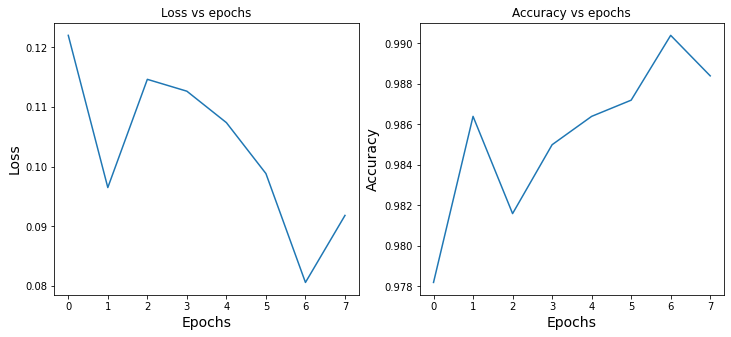

In [44]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].set_title('Loss vs epochs')
axes[0].plot(train_loss_results)

axes[1].set_title('Accuracy vs epochs')
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Evaluate the model performance on the test dataset

In [45]:
# Compute the test loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

for x, y in test_dataset:
    model_output = resnet_model(x)
    epoch_loss_avg(loss_obj(y, model_output))  
    epoch_accuracy(to_categorical(y), model_output)

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 1.098
Test accuracy: 82.870%


#### Model predictions


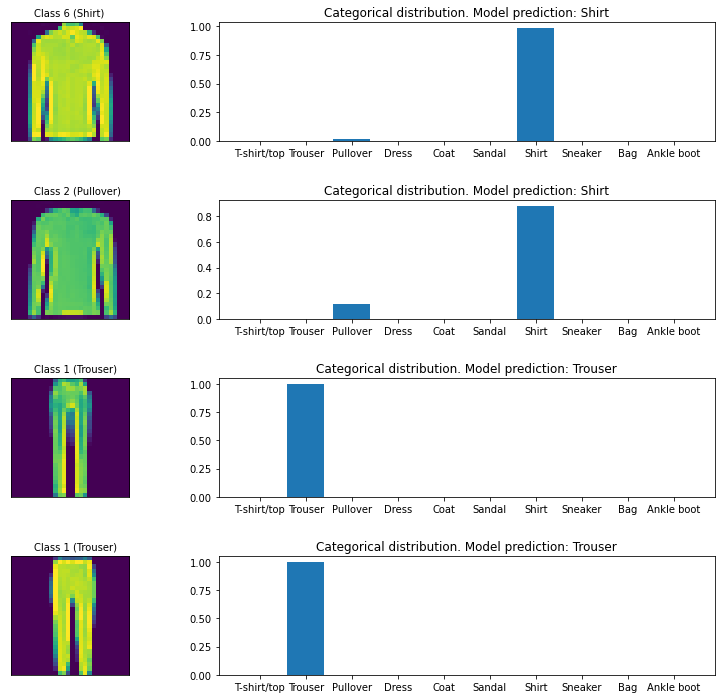

In [46]:
# Get model predictions on randomly selected test images

num_test_images = test_images.shape[0]

random_inx = np.random.choice(test_images.shape[0], 4)
random_test_images = test_images[random_inx, ...]
random_test_labels = test_labels[random_inx, ...]

predictions = resnet_model(random_test_images)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.5, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(5., -2., f'Class {label} ({image_labels[label]})')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_xticklabels(image_labels, rotation=0)
    pred_inx = np.argmax(prediction)
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {image_labels[pred_inx]}")
    
plt.show()